In [1]:
## Cargo las librerias
import numpy as np
import pandas as pd
from os import path


##Librerias de tiempo
import time
from datetime import datetime
import time

##Librerías utilizadas para el muestreo de género de las peliculas
from collections import Counter
from random import uniform
from random import random, randint
from bisect import bisect

##Separar training y test
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

##Metricas
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn import metrics

##Modelos
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

##Graficos
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


/Users/Mauro/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#################################################################################################################################
##Importo el archivo
#################################################################################################################################
movie_completo = pd.read_csv('./4_movie_completo.csv', sep = ';')


In [3]:
movie_completo.shape

(3295, 18480)

## Trabajo con el Target GENERO

In [4]:
##Analizo el target
movie_completo.genero.value_counts()

Drama          1136
Comedy          727
Action          340
Adventure       213
Thriller        199
Crime           166
Romance         144
Horror          128
Mystery          47
Sci-Fi           47
Fantasy          37
Family           35
Documentary      16
Animation        13
Music            12
Biography        11
Sport             8
History           6
Western           6
War               4
Name: genero, dtype: int64

In [9]:
##Filtro los generos para quedarme con los que tiene frecuencia mayor a 20 peliculas
frec_genero = pd.DataFrame(movie_completo.genero.value_counts())
frec_genero = frec_genero.loc[frec_genero.genero >20,:].index.tolist()

movie_genero = movie_completo.loc[[i in frec_genero for i in movie_completo.genero], :]

In [10]:
movie_genero.shape

(3219, 18480)

In [6]:
##Analizo el target
movie_genero.genero.value_counts()

Drama        1136
Comedy        727
Action        340
Adventure     213
Thriller      199
Crime         166
Romance       144
Horror        128
Mystery        47
Sci-Fi         47
Fantasy        37
Family         35
Name: genero, dtype: int64

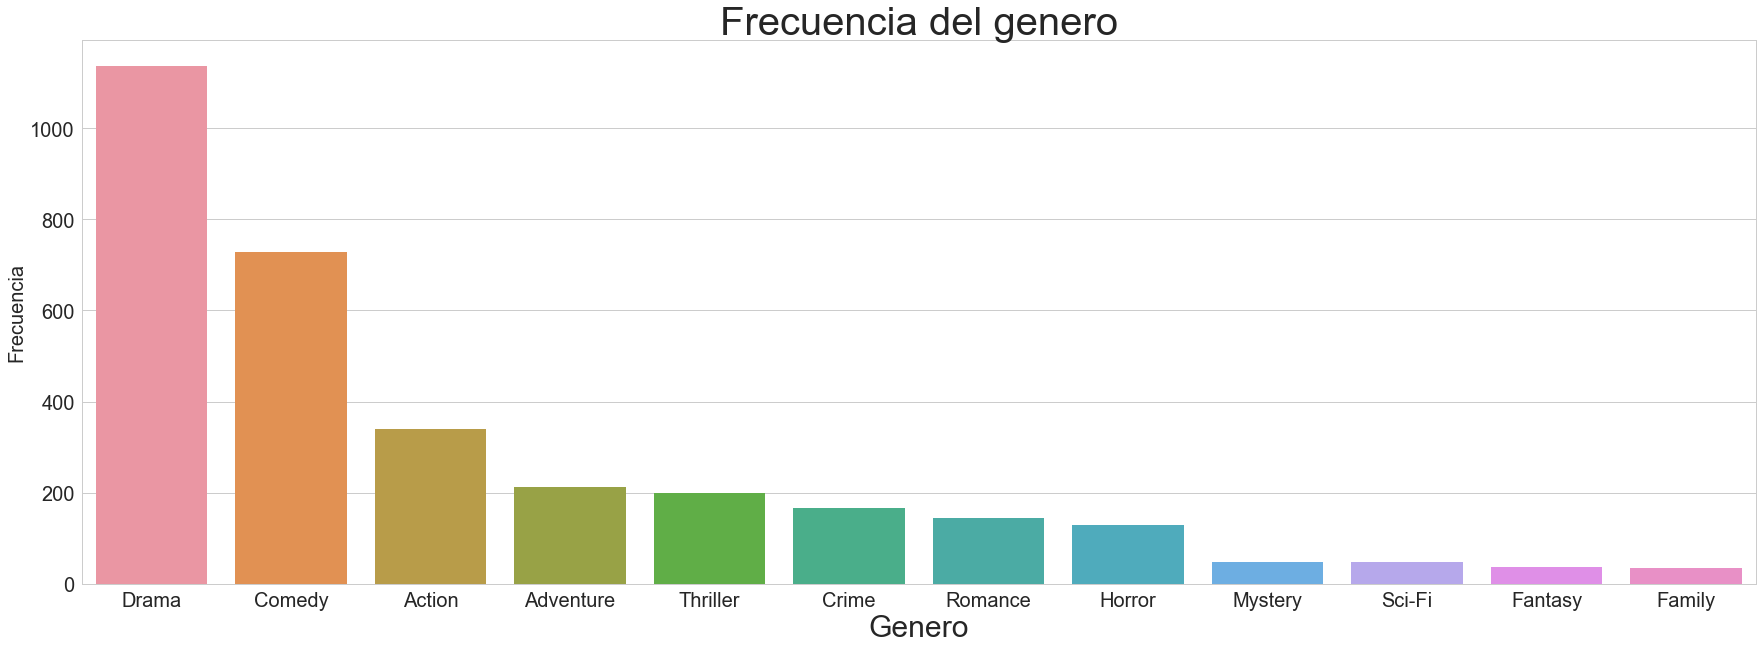

In [7]:
#### Grafico la frecuencia para genero
grafico_genero = {'genero':  movie_genero.genero.value_counts().index.tolist(), 'frecuencia':movie_genero.genero.value_counts()}
grafico_genero = pd.DataFrame(grafico_genero)

plt.figure(figsize=(30,10))
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="genero", y="frecuencia", data=grafico_genero)
ax.axes.set_title("Frecuencia del genero",fontsize=40)
ax.set_xlabel("Genero",fontsize=30)
ax.set_ylabel("Frecuencia",fontsize=20)
ax.tick_params(labelsize=20)

In [125]:
#######Miro las frecuencias de las palabras por genero
exclude = ['imdb_id','actors', 'awards', 'box_office', 'country', 'director_y', 'dvd_y',
           'genre', 'id_movie', 'imdb_rating', 'imdb_votes', 'language',
           'metascore', 'plot_y', 'poster_y', 'production', 'rated', 'released',
           'response', 'runtime', 'title', 'type_y', 'website', 'writer_y', 'year']
include = [x for x in list(movie_genero.columns) if x not in exclude]

filtro = movie_genero.loc[:, include].groupby('genero').apply(sum)
filtro = filtro.drop('genero', axis=1)

In [128]:
generos_frec = pd.merge(Drama, Comedy, how='outer', on='word', suffixes=('_Drama', '_Comedy'))

for i in [x for x in filtro.index.tolist() if x not in ['Drama', 'Comedy']]:
    filtro1 = {'word': filtro[filtro.index == i].columns.tolist(), 'frec_'+i: filtro[filtro.index == i].values.tolist()[0]}
    filtro1 = pd.DataFrame(filtro1)
    filtro1=filtro1.loc[filtro1['frec_'+i] >0,:].sort_values(by = 'frec_'+i, ascending = False)
    generos_frec = pd.merge(generos_frec, filtro1, how='outer', on='word')

In [130]:
null_data = generos_frec[generos_frec.isnull().any(axis=1)]

In [131]:
###Reorganizo las salidas
generos_frec = generos_frec[['word', 'frec_Drama', 'frec_Comedy', 'frec_Action', 'frec_Adventure',
                             'frec_Crime', 'frec_Family', 'frec_Fantasy', 'frec_Horror',
                             'frec_Mystery', 'frec_Romance', 'frec_Sci-Fi', 'frec_Thriller']]

In [132]:
generos_frec.to_csv('5_generos_frec.csv', sep=';', index = False)

In [61]:
generos_frec['Total'] = generos_frec.iloc[:,1:].notnull().sum(axis=1)

/Users/Mauro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
generos_frec = generos_frec.sort_values('Total', ascending=False)
##Las palabras que aparece en los doce generos deberia sacarlas

In [71]:
##Filtro las palabras que aparecen en los doce generos
generos_frec.loc[generos_frec.Total ==11, 'word']


68      door
5       shit
46    actual
77      book
1       fuck
Name: word, dtype: object

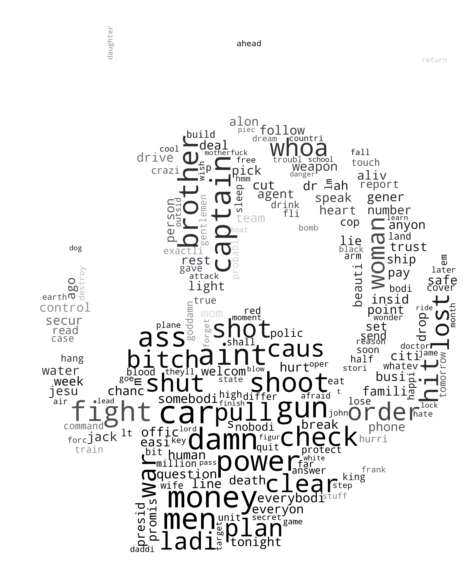

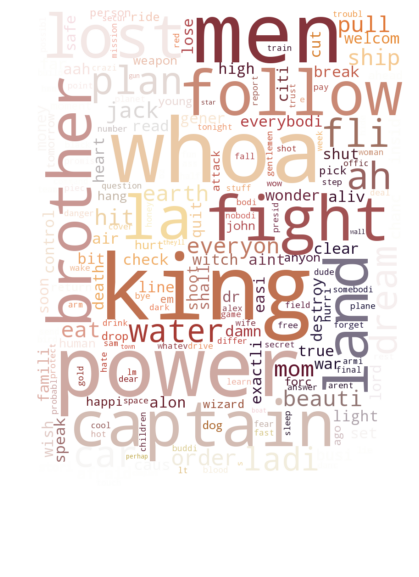

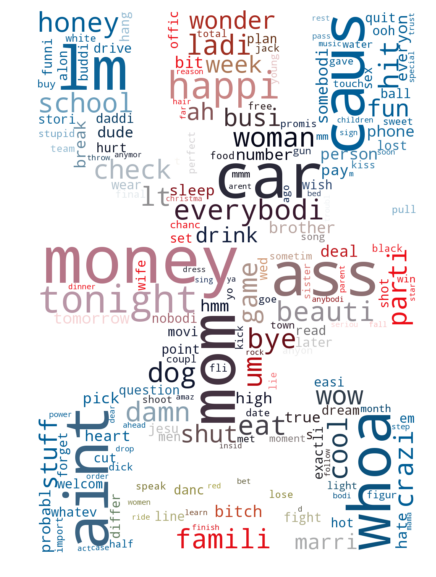

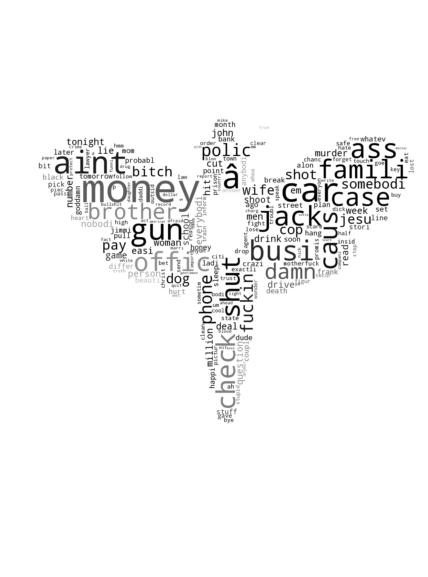

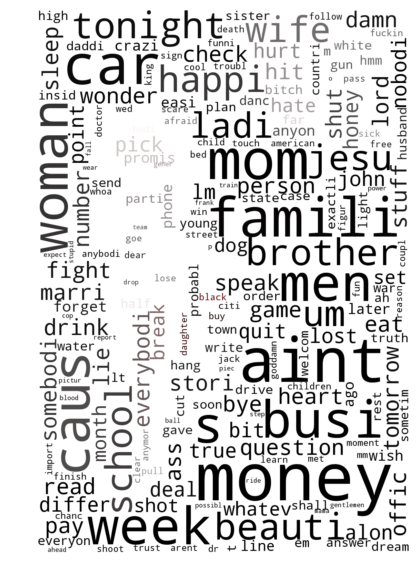

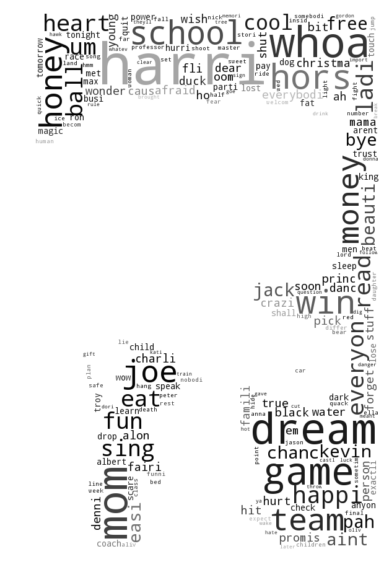

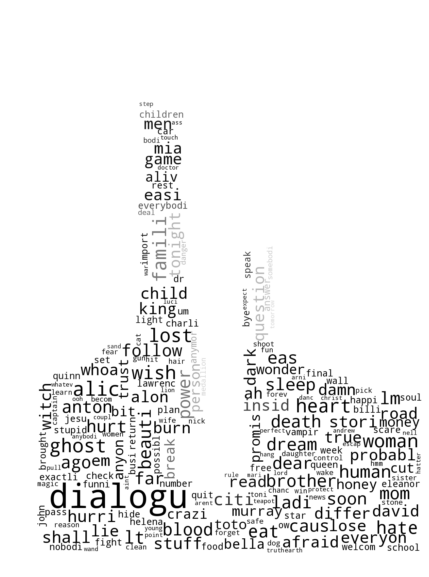

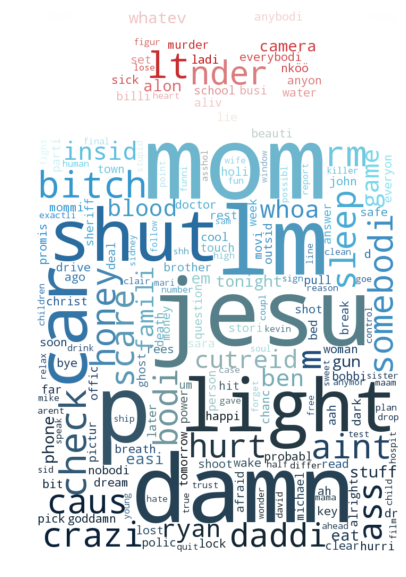

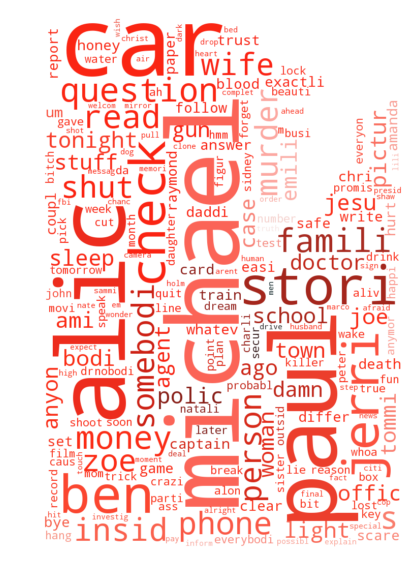

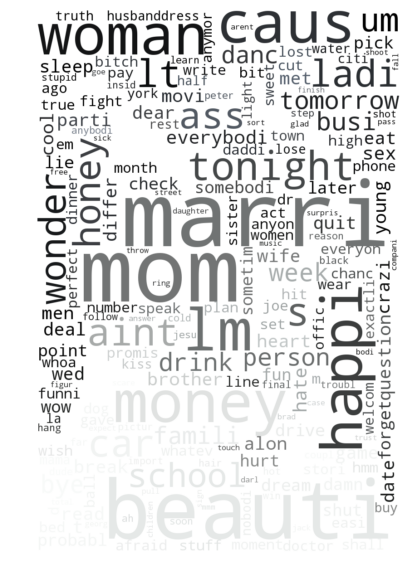

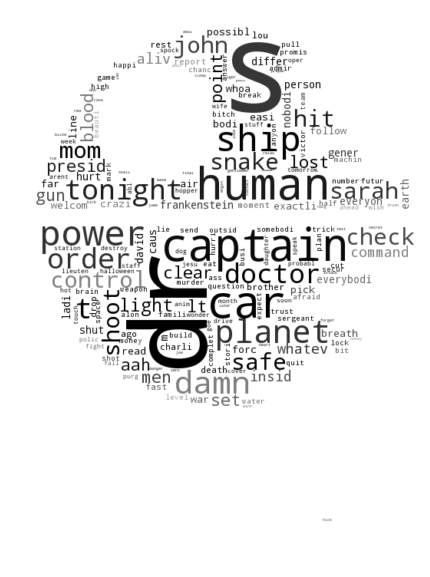

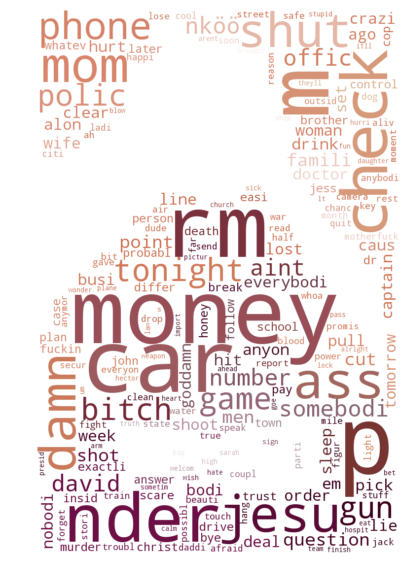

In [72]:
######### Wordcloud ##################
exclude = ['imdb_id','actors', 'awards', 'box_office', 'country', 'director_y', 'dvd_y',
           'genre', 'id_movie', 'imdb_rating', 'imdb_votes', 'language',
           'metascore', 'plot_y', 'poster_y', 'production', 'rated', 'released',
           'response', 'runtime', 'title', 'type_y', 'website', 'writer_y', 'year','genero',
           'okay', 'ta', 'ok', 'mother', 'dad', 'son', 'save', 'father', 'huh','babi', 'wan', 'uh', 'sir', 'l',
           'door', 'shit', 'actual', 'book', 'fuck']
include = [x for x in list(movie_genero.columns) if x not in exclude]

for i in np.unique(movie_genero.genero):
    filtro = movie_genero.loc[movie_genero.genero == i, include].apply(sum)
    filtro = {'word': filtro.index.tolist(), 'frec': filtro}
    filtro = pd.DataFrame(filtro)
    
    d = {}
    for x, a in filtro.values:
        d[a] = x

    mask = np.array(Image.open("./mask/"+i+".png"))

    wc = WordCloud(background_color="white", mask=mask)
    wc.generate_from_frequencies(frequencies=d)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)

    # show
    plt.figure(figsize=(20,10))
    # recolor wordcloud and show
    # we could also give color_func=image_colors directly in the constructor
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    # store to file
    wc.to_file("./mask/wc_"+i+"2.png")


In [11]:
##Como esta desbalanceado el target lo balanceo haciendo muestreo con reposición de cada clase desbalanceada.
def balance_target(dataset, target):
    movie_muestreado  = pd.DataFrame()
    cant_catg = 0
    ##Guardo la maxima frecuencia
    max_frec = max(dataset[target].value_counts())
    
    for i in dataset[target].value_counts().index.tolist():
        ##Filtro
        subset = dataset.loc[dataset[target] == i, :] 
        if subset.shape[0] == max_frec:
            movie_muestreado = pd.concat([movie_muestreado, subset], axis=0)
            cant_catg += 1
            print('Cantidad de categorias procesadas: ', cant_catg, 'de un total de: ', len(dataset[target].value_counts()))
        else:
            ##Remuestreo con reposicion
            subset = subset.sample(n=max_frec, replace=True, random_state=17)
            movie_muestreado = pd.concat([movie_muestreado, subset], axis=0)
            cant_catg += 1

            print('Cantidad de categorias procesadas: ', cant_catg, 'de un total de: ', len(dataset[target].value_counts()))
    
    return movie_muestreado

In [12]:
movie_muestreado = balance_target(movie_genero, 'genero')

Cantidad de categorias procesadas:  1 de un total de:  12
Cantidad de categorias procesadas:  2 de un total de:  12
Cantidad de categorias procesadas:  3 de un total de:  12
Cantidad de categorias procesadas:  4 de un total de:  12
Cantidad de categorias procesadas:  5 de un total de:  12
Cantidad de categorias procesadas:  6 de un total de:  12
Cantidad de categorias procesadas:  7 de un total de:  12
Cantidad de categorias procesadas:  8 de un total de:  12
Cantidad de categorias procesadas:  9 de un total de:  12
Cantidad de categorias procesadas:  10 de un total de:  12
Cantidad de categorias procesadas:  11 de un total de:  12
Cantidad de categorias procesadas:  12 de un total de:  12


In [13]:
print(movie_muestreado.shape)
movie_muestreado.genero.value_counts()

(13632, 18480)


Thriller     1136
Drama        1136
Fantasy      1136
Romance      1136
Sci-Fi       1136
Horror       1136
Family       1136
Crime        1136
Mystery      1136
Adventure    1136
Action       1136
Comedy       1136
Name: genero, dtype: int64

In [22]:
##Me quedo con el target genero spliteo en training y testing
exclude = ['imdb_id','actors', 'awards', 'box_office', 'country', 'director_y', 'dvd_y',
           'genre', 'id_movie', 'imdb_rating', 'imdb_votes', 'language',
           'metascore', 'plot_y', 'poster_y', 'production', 'rated', 'released',
           'response', 'runtime', 'title', 'type_y', 'website', 'writer_y', 'year','genero',
           'okay', 'ta', 'ok', 'mother', 'dad', 'son', 'save', 'father', 'huh','babi', 'wan', 'uh', 'sir', 'l',
           'door', 'shit', 'actual', 'book', 'fuck']
include = [x for x in list(movie_muestreado.columns) if x not in exclude]

x = np.array(movie_muestreado[include])
#y = np.array(movie_muestreado['genero'])

lab_enc = LabelEncoder()
lab_enc.fit(movie_muestreado['genero'])
y = lab_enc.transform(movie_muestreado['genero'])

##Splite en test y training
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=53)


Accuray:  0.872127139364
Duration: 0:00:04.524063


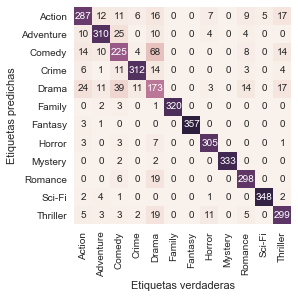

In [23]:
#####################################################################
########################      Naive bayes    ########################
####################################################################
hora_ini = datetime.now()

#instancio el modelo
model = MultinomialNB()

model.fit(X_train, y_train)

##predigo los campos
bayes_test = model.predict(X_test)

##Calculo scores y area bajo la curva ROC
print('Accuray: ', accuracy_score(y_test,bayes_test))
#print('AUC: ',roc_auc_score(y_test,bayes_test))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, bayes_test)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))

In [ ]:
#############################################################
############################# KNN ###########################
#############################################################
hora_ini = datetime.now()

# Elegimos el modelo óptimo que nos había indicado cross validation
model_knn = KNeighborsClassifier(n_neighbors= 12)
# Lo ajustamos sobre datos de entrenamiento
model_knn.fit(X_train,y_train)
# Lo utilizamos para predecir en test
y_pred = model_knn.predict(X_test)
print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))


In [ ]:
########################################################################
############################# KNN Optimizado ###########################
########################################################################
hora_ini = datetime.now()

k_range = list(range(5, 12))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
knn = KNeighborsClassifier()
model_knn_op = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
model_knn_op.fit(X_train, y_train)
print (grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

y_pred = model_knn_op.predict(X_test)
print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))

Rendimiento de Random Forest:	0.908 ± 0.006
Accuray:  0.925672371638
             precision    recall  f1-score   support

          0       0.92      0.82      0.87       393
          1       0.98      0.90      0.94       386
          2       0.76      0.73      0.74       346
          3       0.99      0.93      0.96       353
          4       0.46      0.75      0.57       201
          5       1.00      0.99      1.00       323
          6       1.00      1.00      1.00       357
          7       1.00      0.98      0.99       339
          8       1.00      1.00      1.00       353
          9       0.99      0.98      0.99       345
         10       1.00      1.00      1.00       333
         11       0.99      0.97      0.98       361

avg / total       0.94      0.93      0.93      4090

Duration: 0:01:35.539984


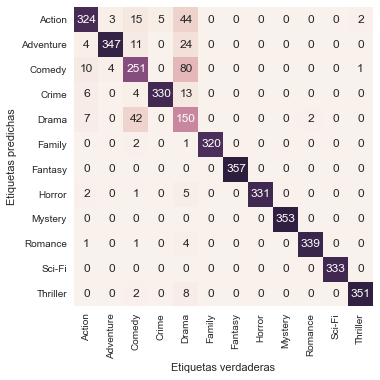

In [76]:
#############################################################
######################## Random Forest ######################
#############################################################
hora_ini = datetime.now()

def evaluar_rendimiento(modelo, nombre):
    s = cross_val_score(modelo, X_train, y_train, cv=5, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

##Instancio el modelo
model_rf = RandomForestClassifier()

##evaluo el modelo
evaluar_rendimiento(model_rf,  "Random Forest")

##Fiteo el modelo
model_rf.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = model_rf.predict(X_test)

print('Accuray: ', accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_pred, y_test))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))


Fitting 3 folds for each of 375 candidates, totalling 1125 fits
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=50 
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=50 
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=50 
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=50, total=  42.8s
[CV]  max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=50, total=  34.0s
[CV]  max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=50, total=  38.8s
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=500, total=  37.5s
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=500 
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=1000 
[CV] max_depth=5, max_features=1, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.6min


[CV] max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=5, max_features=1, min_samples_leaf=10, n_estimators=1000, total= 1.1min
[CV] max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=5, max_features=1, min_samples_leaf=10, n_estimators=1000, total= 1.2min
[CV]  max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=50, total=  47.4s
[CV] max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=5, max_features=1, min_samples_leaf=10, n_estimators=1000, total= 1.2min
[CV]  max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=50, total=  46.0s
[CV] max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=500 
[CV] max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=500 
[CV]  max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=50, total=  31.4s
[CV] max_depth=5, max_features=1, min_samples_leaf=50, n_estimators=500 
[CV] max_depth=5, max_features=1, min

[CV]  max_depth=5, max_features=5, min_samples_leaf=50, n_estimators=500, total=  27.9s
[CV] max_depth=5, max_features=5, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, n_estimators=500, total=  31.3s
[CV] max_depth=5, max_features=5, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, n_estimators=500, total=  37.7s
[CV] max_depth=5, max_features=8, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, n_estimators=1000, total=  49.5s
[CV] max_depth=5, max_features=8, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_leaf=1, n_estimators=50, total=  24.2s
[CV] max_depth=5, max_features=8, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=5, max_features=5, min_samples_leaf=50, n_estimators=1000, total=  46.3s
[CV] max_depth=5, max_features=8, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=5, max_features=5, min_

[CV]  max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=50, total=  27.3s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=50, total=  24.9s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=500 
[CV] max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=500, total=  33.3s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=500, total=  34.0s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=500, total=  39.2s
[CV] max_depth=5, max_features=10, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=5, max_features=10, min_samples_leaf=1, n_estimators=1000, total=  56.5s
[CV] max_depth=5, max_features=10

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 34.9min


[CV]  max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=50, total=  31.7s
[CV] max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=500 
[CV]  max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=50, total=  33.2s
[CV] max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=500 
[CV] max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=500, total=  46.4s
[CV] max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=500, total=  40.5s
[CV] max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=5, max_features=10, min_samples_leaf=8, n_estimators=500, total=  41.2s
[CV] max_depth=5, max_features=10, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=5, max_features=10, min_samples_leaf=10, n_estimators=50, total=  24.5s
[CV] max_depth=5, max_features=10

[CV] max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=5, max_features=21, min_samples_leaf=8, n_estimators=1000, total= 1.1min
[CV] max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=50, total=  19.6s
[CV] max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=5, max_features=21, min_samples_leaf=8, n_estimators=1000, total= 1.1min
[CV] max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=5, max_features=21, min_samples_leaf=8, n_estimators=1000, total= 1.1min
[CV]  max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=50, total=  29.1s
[CV] max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=500 
[CV] max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=1000 
[CV]  max_depth=5, max_features=21, min_samples_leaf=10, n_estimators=500, total=  45.4s
[CV] max_depth=5, max_fea

[CV] max_depth=20, max_features=1, min_samples_leaf=10, n_estimators=1000 
[CV]  max_depth=20, max_features=1, min_samples_leaf=10, n_estimators=500, total=  32.6s
[CV] max_depth=20, max_features=1, min_samples_leaf=10, n_estimators=1000 
[CV]  max_depth=20, max_features=1, min_samples_leaf=10, n_estimators=500, total=  36.9s
[CV] max_depth=20, max_features=1, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=20, max_features=1, min_samples_leaf=10, n_estimators=1000, total=  50.7s
[CV] max_depth=20, max_features=1, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=20, max_features=1, min_samples_leaf=50, n_estimators=50, total=  27.0s
[CV]  max_depth=20, max_features=1, min_samples_leaf=10, n_estimators=1000, total=  46.9s
[CV] max_depth=20, max_features=1, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=20, max_features=1, min_samples_leaf=10, n_estimators=1000, total=  43.4s
[CV] max_depth=20, max_features=1, min_samples_leaf=50, n_estimators=500 
[CV]  max_depth=20, m

[CV]  max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=50, total=  26.0s
[CV] max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=500 
[CV]  max_depth=20, max_features=5, min_samples_leaf=10, n_estimators=1000, total= 1.0min
[CV] max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=500 
[CV] max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=500, total=  31.4s
[CV] max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=500, total=  33.5s
[CV] max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=500, total=  41.1s
[CV] max_depth=20, max_features=8, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=20, max_features=5, min_samples_leaf=50, n_estimators=1000, total=  58.0s
[CV] max_depth=20, m

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 83.6min


[CV] max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=20, max_features=8, min_samples_leaf=50, n_estimators=1000, total= 1.0min
[CV] max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=50, total=  26.1s
[CV] max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=20, max_features=8, min_samples_leaf=50, n_estimators=1000, total=  56.8s
[CV] max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=20, max_features=8, min_samples_leaf=50, n_estimators=1000, total=  55.3s
[CV]  max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=50, total=  31.3s
[CV] max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=50, total=  31.1s
[CV] max_depth=20, max_features=10, min_samples_leaf=1, n_estimators=500 
[CV] max_depth=20, max_fe

[CV]  max_depth=20, max_features=21, min_samples_leaf=1, n_estimators=50, total=  32.1s
[CV] max_depth=20, max_features=21, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=20, max_features=21, min_samples_leaf=1, n_estimators=500, total= 1.3min
[CV] max_depth=20, max_features=21, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=20, max_features=21, min_samples_leaf=1, n_estimators=500, total= 1.3min
[CV] max_depth=20, max_features=21, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=20, max_features=21, min_samples_leaf=1, n_estimators=500, total= 1.3min
[CV] max_depth=20, max_features=21, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=20, max_features=21, min_samples_leaf=5, n_estimators=50, total=  23.3s
[CV] max_depth=20, max_features=21, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=20, max_features=21, min_samples_leaf=5, n_estimators=50, total=  24.5s
[CV] max_depth=20, max_features=21, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=20, max_f

[CV] max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=50, total=  25.3s
[CV] max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=500 
[CV]  max_depth=50, max_features=1, min_samples_leaf=1, n_estimators=1000, total= 1.1min
[CV]  max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=50, total=  23.5s
[CV] max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=500 
[CV] max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=500 
[CV]  max_depth=50, max_features=1, min_samples_leaf=1, n_estimators=1000, total= 1.2min
[CV] max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=1000 
[CV]  max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=500, total=  33.5s
[CV] max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=1000 
[CV]  max_depth=50, max_features=1, min_samples_leaf=5, n_estimators=500, total=  39.0s
[CV] max_depth=50, max_features=1

[CV] max_depth=50, max_features=5, min_samples_leaf=5, n_estimators=1000 
[CV]  max_depth=50, max_features=5, min_samples_leaf=5, n_estimators=500, total=  51.8s
[CV] max_depth=50, max_features=5, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=50, max_features=5, min_samples_leaf=8, n_estimators=50, total=  20.1s
[CV] max_depth=50, max_features=5, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=50, max_features=5, min_samples_leaf=5, n_estimators=1000, total= 1.2min
[CV] max_depth=50, max_features=5, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=50, max_features=5, min_samples_leaf=8, n_estimators=50, total=  27.7s
[CV]  max_depth=50, max_features=5, min_samples_leaf=5, n_estimators=1000, total= 1.3min
[CV] max_depth=50, max_features=5, min_samples_leaf=8, n_estimators=500 
[CV] max_depth=50, max_features=5, min_samples_leaf=8, n_estimators=500 
[CV]  max_depth=50, max_features=5, min_samples_leaf=5, n_estimators=1000, total= 1.3min
[CV]  max_depth=50, max_features=5,

[CV] max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=500 
[CV]  max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=50, total=  24.5s
[CV] max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=500, total=  53.2s
[CV] max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=500, total=  54.8s
[CV] max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=500, total=  53.3s
[CV] max_depth=50, max_features=8, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=50, max_features=8, min_samples_leaf=10, n_estimators=50, total=  23.1s
[CV] max_depth=50, max_features=8, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=50, max_features=8, min_samples_leaf=8, n_estimators=1000, total= 1.4min
[CV] max_depth=50, max_features

[CV]  max_depth=50, max_features=10, min_samples_leaf=8, n_estimators=1000, total= 1.6min
[CV] max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=50, total=  23.8s
[CV] max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=50, total=  21.1s
[CV] max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=50, max_features=10, min_samples_leaf=8, n_estimators=1000, total= 1.5min
[CV] max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=50, max_features=10, min_samples_leaf=8, n_estimators=1000, total= 1.5min
[CV] max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=1000 
[CV]  max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=500, total=  59.5s
[CV] max_depth=50, max_features=10, min_samples_leaf=10, n_estimators=1000 
[CV]  max_d

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 165.1min


[CV] max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=500 
[CV]  max_depth=50, max_features=21, min_samples_leaf=1, n_estimators=1000, total= 2.8min
[CV]  max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=500, total= 1.3min
[CV] max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=500 
[CV]  max_depth=50, max_features=21, min_samples_leaf=1, n_estimators=1000, total= 2.8min
[CV]  max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=500, total= 1.3min
[CV] max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=1000 
[CV] max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=1000 
[CV] max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=1000 
[CV]  max_depth=50, max_features=21, min_samples_leaf=5, n_estimators=500, total= 1.3min
[CV] max_depth=50, max_features=21, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=50, max_features=21, min_samples_leaf=8, n_estimators=50, total=  22.5s
[CV] max_depth=50, 

[CV]  max_depth=70, max_features=1, min_samples_leaf=5, n_estimators=1000, total=  50.7s
[CV] max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=50, total=  25.9s
[CV] max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=70, max_features=1, min_samples_leaf=5, n_estimators=1000, total=  50.1s
[CV] max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=500 
[CV]  max_depth=70, max_features=1, min_samples_leaf=5, n_estimators=1000, total=  46.1s
[CV]  max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=50, total=  27.0s
[CV] max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=500 
[CV] max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=500 
[CV]  max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=50, total=  25.8s
[CV] max_depth=70, max_features=1, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=70, max_features=1,

[CV]  max_depth=70, max_features=5, min_samples_leaf=8, n_estimators=500, total=  43.9s
[CV] max_depth=70, max_features=5, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=70, max_features=5, min_samples_leaf=8, n_estimators=500, total=  43.4s
[CV] max_depth=70, max_features=5, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=70, max_features=5, min_samples_leaf=8, n_estimators=500, total=  46.0s
[CV] max_depth=70, max_features=5, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=70, max_features=5, min_samples_leaf=10, n_estimators=50, total=  23.6s
[CV] max_depth=70, max_features=5, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=70, max_features=5, min_samples_leaf=8, n_estimators=1000, total= 1.2min
[CV] max_depth=70, max_features=5, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=70, max_features=5, min_samples_leaf=10, n_estimators=50, total=  24.6s
[CV] max_depth=70, max_features=5, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=70, max_featur

[CV]  max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=50, total=  28.6s
[CV] max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=70, max_features=8, min_samples_leaf=8, n_estimators=1000, total= 1.5min
[CV] max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=70, max_features=8, min_samples_leaf=8, n_estimators=1000, total= 1.5min
[CV] max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=1000 
[CV]  max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=500, total=  57.8s
[CV] max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=1000 
[CV]  max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=500, total=  54.2s
[CV] max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=1000 
[CV]  max_depth=70, max_features=8, min_samples_leaf=10, n_estimators=500, total=  54.3s
[CV] max_depth=70, max_features=8, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=70, m

[CV] max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=50, total=  19.1s
[CV] max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=50 
[CV]  max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=50, total=  21.0s
[CV]  max_depth=70, max_features=10, min_samples_leaf=10, n_estimators=1000, total= 1.4min
[CV] max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=50 
[CV] max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=500 
[CV]  max_depth=70, max_features=10, min_samples_leaf=10, n_estimators=1000, total= 1.4min
[CV] max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=500 
[CV]  max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=50, total=  26.8s
[CV] max_depth=70, max_features=10, min_samples_leaf=50, n_estimators=500 
[CV]  max_depth=70, max_features=10, min_samples_leaf=10, n_estimators=1000, total= 1.5min
[CV] max_dept

[CV]  max_depth=70, max_features=21, min_samples_leaf=10, n_estimators=1000, total= 2.2min
[CV] max_depth=70, max_features=21, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=70, max_features=21, min_samples_leaf=50, n_estimators=500, total=  53.9s
[CV] max_depth=70, max_features=21, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=70, max_features=21, min_samples_leaf=50, n_estimators=500, total=  53.8s
[CV] max_depth=70, max_features=21, min_samples_leaf=50, n_estimators=1000 
[CV]  max_depth=70, max_features=21, min_samples_leaf=50, n_estimators=500, total=  56.2s
[CV] max_depth=100, max_features=1, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=100, max_features=1, min_samples_leaf=1, n_estimators=50, total=  19.8s
[CV] max_depth=100, max_features=1, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=70, max_features=21, min_samples_leaf=50, n_estimators=1000, total= 1.4min
[CV] max_depth=100, max_features=1, min_samples_leaf=1, n_estimators=50 
[CV]  max_dep

[CV]  max_depth=100, max_features=1, min_samples_leaf=50, n_estimators=1000, total=  43.3s
[CV] max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=50 
[CV]  max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=50, total=  33.6s
[CV]  max_depth=100, max_features=1, min_samples_leaf=50, n_estimators=1000, total=  44.7s
[CV] max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=500 
[CV] max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=50, total=  33.7s
[CV] max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=500 
[CV]  max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=50, total=  28.7s
[CV] max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=500, total= 1.0min
[CV] max_depth=100, max_features=5, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=100,

[CV] max_depth=100, max_features=8, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=100, max_features=8, min_samples_leaf=1, n_estimators=500, total= 1.1min
[CV] max_depth=100, max_features=8, min_samples_leaf=1, n_estimators=1000 
[CV]  max_depth=100, max_features=8, min_samples_leaf=1, n_estimators=500, total= 1.1min
[CV] max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=50, total=  23.0s
[CV] max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=50, total=  23.3s
[CV] max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=50 
[CV]  max_depth=100, max_features=8, min_samples_leaf=1, n_estimators=1000, total= 1.8min
[CV] max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=500 
[CV]  max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=50, total=  24.9s
[CV] max_depth=100, max_f

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 274.1min


[CV] max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=50, total=  21.1s
[CV] max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=1000, total= 1.5min
[CV] max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=50 
[CV]  max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=50, total=  25.3s
[CV] max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=500 
[CV]  max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=1000, total= 1.6min
[CV]  max_depth=100, max_features=8, min_samples_leaf=5, n_estimators=1000, total= 1.5min
[CV] max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=500 
[CV]  max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=50, total=  23.3s
[CV] max_depth=100, max_features=8, min_samples_leaf=8, n_estimators=500 
[CV] max_depth=100, max_f

[CV]  max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=50, total=  27.4s
[CV] max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=500 
[CV] max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=500, total=  56.0s
[CV] max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=500, total=  55.1s
[CV] max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=1000 
[CV]  max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=500, total=  58.8s
[CV] max_depth=100, max_features=10, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=100, max_features=10, min_samples_leaf=10, n_estimators=50, total=  21.7s
[CV] max_depth=100, max_features=10, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=100, max_features=10, min_samples_leaf=8, n_estimators=1000, total= 1.7min
[CV]  m

[CV]  max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=50, total=  23.1s
[CV] max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=50, total=  23.0s
[CV] max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=50 
[CV]  max_depth=100, max_features=21, min_samples_leaf=8, n_estimators=1000, total= 2.3min
[CV] max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=50, total=  26.2s
[CV] max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=100, max_features=21, min_samples_leaf=8, n_estimators=1000, total= 2.4min
[CV] max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=500 
[CV]  max_depth=100, max_features=21, min_samples_leaf=8, n_estimators=1000, total= 2.3min
[CV] max_depth=100, max_features=21, min_samples_leaf=10, n_estimators=1000 
[C

[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 313.4min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features=8,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuray:  0.961613691932
             precision    recall  f1-score   support

          0       0.99      0.91      0.95       354
          1       1.00      0.98      0.99       354
          2       0.98      0.69      0.81       329
          3       1.00      0.99      0.99       335
          4       0.68      0.98      0.81       329
          5       1.00      1.00      1.00       320
          6       1.00      1.00      1.00       357
          7       1.00      1.00      1.00       331
          8       1.00      1.00      1.00       353
          9       1.00      0.99      1.00     

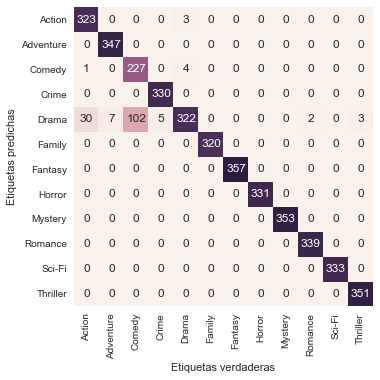

In [11]:
########################################################################
######################## Random Forest OPTIMIZADO ######################
########################################################################
hora_ini = datetime.now()

##Configuro los parametros
param_trees = {'n_estimators': [50, 500, 1000], 
               'max_features': [1, 5, 8, 10, 21], 
               'max_depth': [5, 20, 50, 70, 100], 
               'min_samples_leaf':[1, 5, 8, 10, 50]}

##Instancio el modelo
model_rf_op = RandomForestClassifier(class_weight='balanced')
kf = StratifiedKFold(n_splits=3, shuffle=True)

## Hago el gridsearch
grid_search_rf = GridSearchCV(model_rf_op, param_grid=param_trees, cv=kf, verbose=2, n_jobs=-1)

##Fiteo el modelo
grid_search_rf.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = grid_search_rf.predict(X_test)

##Veo cual es la configuracion del mejor estimador
print(grid_search_rf.best_estimator_)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))


In [ ]:
################################################################
########################     ADABOOST      ######################
################################################################
hora_ini = datetime.now()

##Configuro los parametros
param_trees = {'n_estimators': [50, 500], 
               'max_depth': [5, 20, 50]}

##Instancio el modelo
model_ada_gen = GradientBoostingClassifier()
kf = StratifiedKFold(n_splits=3, shuffle=True)

## Hago el gridsearch
grid_search_ada_gen = GridSearchCV(model_ada_gen, param_grid=param_trees, cv=kf, verbose=2, n_jobs=-1)


##Fiteo el modelo
grid_search_ada_gen.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = grid_search_ada_gen.predict(X_test)

##Veo cual es la configuracion del mejor estimador
print(grid_search_ada_gen.best_estimator_)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))



Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=5, n_estimators=50 ....................................
[CV] max_depth=5, n_estimators=50 ....................................
[CV] max_depth=5, n_estimators=50 ....................................
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .................... max_depth=5, n_estimators=50, total=436.3min
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .................... max_depth=5, n_estimators=50, total=437.9min
[CV] .................... max_depth=5, n_estimators=50, total=438.0min
[CV] max_depth=5, n_estimators=500 ...................................
[CV] max_depth=20, n_estimators=50 ...................................
[CV] .................. max_depth=20, n_estimators=50, total=2216.9min
[CV] max_depth=20, n_estimators=50 ...................................


Accuray:  0.897555012225
             precision    recall  f1-score   support

          0       0.89      0.83      0.86       354
          1       0.87      0.95      0.90       354
          2       0.79      0.69      0.73       329
          3       0.90      0.95      0.93       335
          4       0.69      0.47      0.56       329
          5       0.97      1.00      0.98       320
          6       0.99      1.00      1.00       357
          7       0.93      0.97      0.95       331
          8       0.98      1.00      0.99       353
          9       0.86      0.97      0.91       341
         10       1.00      1.00      1.00       333
         11       0.83      0.92      0.88       354

avg / total       0.89      0.90      0.89      4090

Duration: 1:41:17.699684


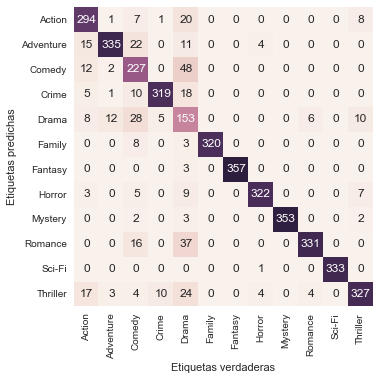

In [10]:
################################################################
########################     XGBOOST      ######################
################################################################
hora_ini = datetime.now()


##Instancio el modelo
model_xgboost = XGBClassifier()


##Fiteo el modelo
model_xgboost.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = model_xgboost.predict(X_test)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))

In [ ]:
################################################################
########################    XGBOOST  Opt  ######################
################################################################
hora_ini = datetime.now()

##Configuro los parametros
param_trees = {'n_estimators': [50, 500], 
               'max_depth': [5, 20], 
               'min_child_weight':[1, 5]}

##Instancio el modelo
model_xgboost = XGBClassifier()
kf = StratifiedKFold(n_splits=3, shuffle=True)

## Hago el gridsearch
grid_search_xgb = GridSearchCV(model_xgboost, param_grid=param_trees, cv=kf, verbose=2, n_jobs=-1)

##Fiteo el modelo
grid_search_xgb.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = grid_search_xgb.predict(X_test)

##Veo cual es la configuracion del mejor estimador
print(grid_search_xgb.best_estimator_)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))



C_Value: [ 0.01  0.02  0.03  0.07  0.1   0.01  0.01  0.07  0.01  0.03  0.1   0.08]
Accuray:  0.935452322738
Duration: 3:12:02.616867


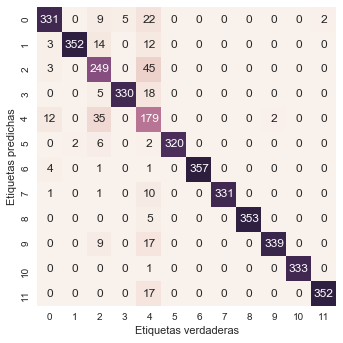

In [ ]:
#############################################################
######################## Reg Logistica ######################
#############################################################
hora_ini = datetime.now()

##Inicializo los parametros
c_values = np.linspace(0.01, 0.1, 10)
kf = KFold(n_splits=5, shuffle=True, random_state=12)

# Instanciamos los modelos
logicCV = LogisticRegressionCV(Cs=c_values, cv=kf, fit_intercept=True)

logicCV.fit(X_train, y_train)

print('C_Value:',logicCV.C_)


logic_Test = logicCV.predict(X_test)

print('Accuray: ', accuracy_score(y_test,logic_Test))
#print('AUC: ',roc_auc_score(y_test,logic_Test))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, logic_Test)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))

## Trabajo con el Target RATED

In [14]:
##Analizo el target
movie_completo.rated.value_counts()

R            1460
PG-13        1085
PG            490
G              81
NOT RATED      71
APPROVED       43
UNRATED        25
NC-17           8
GP              4
PASSED          3
TV-G            3
TV-14           2
TV-PG           1
NR              1
TV-MA           1
Name: rated, dtype: int64

In [15]:
##Filtro los rated oficiales
rated = ['G', 'PG', 'PG-13', 'R', 'NC-17']
movie_rated = movie_completo.loc[(~movie_completo.rated.isnull()) & (movie_completo.rated.isin(rated)),:]

In [16]:
print(movie_rated.shape)
movie_rated.rated.value_counts()

(3124, 18480)


R        1460
PG-13    1085
PG        490
G          81
NC-17       8
Name: rated, dtype: int64

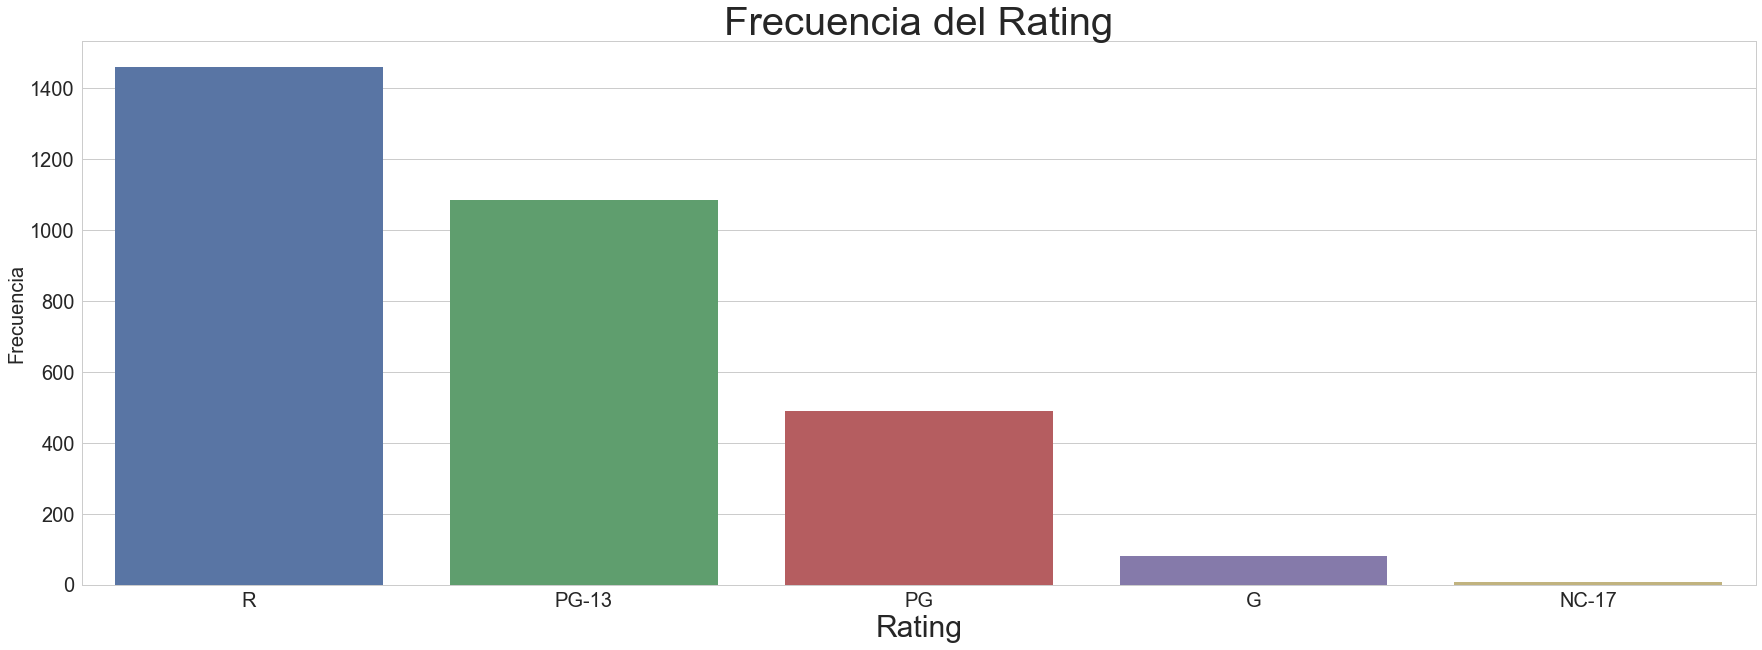

In [22]:
#### Grafico la frecuencia para genero
grafico_rating = {'genero':  movie_rated.rated.value_counts().index.tolist(), 'frecuencia':movie_rated.rated.value_counts()}
grafico_rating = pd.DataFrame(grafico_rating)

plt.figure(figsize=(30,10))
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="genero", y="frecuencia", data=grafico_rating)
ax.axes.set_title("Frecuencia del Rating",fontsize=40)
ax.set_xlabel("Rating",fontsize=30)
ax.set_ylabel("Frecuencia",fontsize=20)
ax.tick_params(labelsize=20)


In [17]:
##Balanceo el target con remuestreo
movie_rated_muest = balance_target(movie_rated, 'rated')

Cantidad de categorias procesadas:  1 de un total de:  5
Cantidad de categorias procesadas:  2 de un total de:  5
Cantidad de categorias procesadas:  3 de un total de:  5
Cantidad de categorias procesadas:  4 de un total de:  5
Cantidad de categorias procesadas:  5 de un total de:  5


In [18]:
print(movie_rated_muest.shape)
movie_rated_muest.rated.value_counts()

(7300, 18480)


PG-13    1460
G        1460
PG       1460
NC-17    1460
R        1460
Name: rated, dtype: int64

In [8]:
##Me quedo con el target genero spliteo en training y testing
exclude = ['imdb_id','actors', 'awards', 'box_office', 'country', 'director_y', 'dvd_y',
           'genre', 'id_movie', 'imdb_rating', 'imdb_votes', 'language',
           'metascore', 'plot_y', 'poster_y', 'production', 'rated', 'released',
           'response', 'runtime', 'title', 'type_y', 'website', 'writer_y', 'year',
           'genero']
include = [x for x in list(movie_rated_muest.columns) if x not in exclude]

x = np.array(movie_rated_muest[include])

##Codifico el target
lab_enc = LabelEncoder()
lab_enc.fit(movie_rated_muest['rated'])
y = lab_enc.transform(movie_rated_muest['rated'])

##Splite en test y training
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=53)


Accuray:  0.885844748858
Duration: 0:00:01.469074


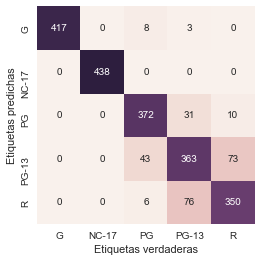

In [15]:
#####################################################################
########################      Naive bayes    ########################
####################################################################
hora_ini = datetime.now()

#instancio el modelo
model = MultinomialNB()

model.fit(X_train, y_train)

##predigo los campos
bayes_test = model.predict(X_test)

##Calculo scores y area bajo la curva ROC
print('Accuray: ', accuracy_score(y_test,bayes_test))
#print('AUC: ',roc_auc_score(y_test,bayes_test))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, bayes_test)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))

In [ ]:
#############################################################
############################# KNN ###########################
#############################################################
hora_ini = datetime.now()

# Elegimos el modelo óptimo que nos había indicado cross validation
model_knn = KNeighborsClassifier(n_neighbors= 5)
# Lo ajustamos sobre datos de entrenamiento
model_knn.fit(X_train,y_train)
# Lo utilizamos para predecir en test
y_pred = model_knn.predict(X_test)
print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))



In [ ]:
########################################################################
############################# KNN Optimizado ###########################
########################################################################
hora_ini = datetime.now()

k_range = list(range(1, 10))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
knn = KNeighborsClassifier(n_neighbors=5)
grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
print (grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

model_knn_op = KNeighborsClassifier(n_neighbors=19, weights='distance')
model_knn_op.fit(X_train, y_train.values.reshape(-1))
y_pred = model_knn_op.predict(X_test)
print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))


Rendimiento de Random Forest:	0.872 ± 0.005
Accuray:  0.890410958904
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       417
          1       1.00      1.00      1.00       438
          2       0.94      0.89      0.91       453
          3       0.78      0.78      0.78       471
          4       0.75      0.79      0.77       411

avg / total       0.89      0.89      0.89      2190

Duration: 0:00:23.096387


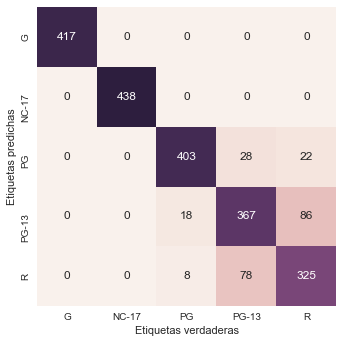

In [16]:
#############################################################
######################## Random Forest ######################
#############################################################
hora_ini = datetime.now()

def evaluar_rendimiento(modelo, nombre):
    s = cross_val_score(modelo, X_train, y_train, cv=5, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

##Instancio el modelo
model_rf = RandomForestClassifier()

##evaluo el modelo
evaluar_rendimiento(model_rf,  "Random Forest")

##Fiteo el modelo
model_rf.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = model_rf.predict(X_test)

print('Accuray: ', accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_pred, y_test))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_), )
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');


print('Duration: {}'.format(datetime.now() - hora_ini))



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features=21,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuray:  0.916894977169
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       417
          1       1.00      1.00      1.00       438
          2       0.94      0.93      0.93       429
          3       0.94      0.73      0.82       473
          4       0.78      0.94      0.85       433

avg / total       0.92      0.92      0.92      2190

Duration: 0:00:00.150665


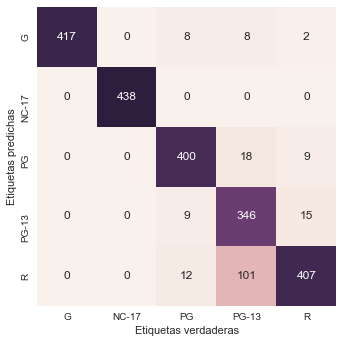

In [121]:
########################################################################
######################## Random Forest OPTIMIZADO ######################
########################################################################
hora_ini = datetime.now()

##Configuro los parametros
param_trees = {'n_estimators': [50, 500, 1000], 
               'max_features': [1, 5, 8, 10, 21], 
               'max_depth': [5, 20, 50, 70, 100], 
               'min_samples_leaf':[1, 5, 8, 10, 50]}

##Instancio el modelo
model_rf_op = RandomForestClassifier(class_weight='balanced')
kf = StratifiedKFold(n_splits=3, shuffle=True)

## Hago el gridsearch
grid_search_rf = GridSearchCV(model_rf_op, param_grid=param_trees, cv=kf, verbose=2, n_jobs=-1)

##Fiteo el modelo
grid_search_rf.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = grid_search_rf.predict(X_test)

##Veo cual es la configuracion del mejor estimador
print(grid_search_rf.best_estimator_)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.set(font_scale=1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))



Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 1361.8min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Accuray:  0.943378995434
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       417
          1       1.00      1.00      1.00       438
          2       0.92      0.96      0.94       429
          3       0.86      0.91      0.88       473
          4       0.97      0.85      0.90       433

avg / total       0.95      0.94      0.94      2190

Duration: 1 day, 6:28:23.553388


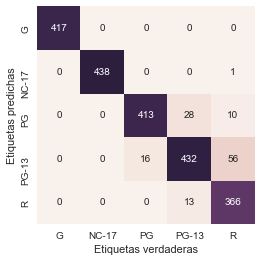

In [13]:
################################################################
########################     ADABOOST      ######################
################################################################
hora_ini = datetime.now()

##Configuro los parametros
param_trees = {'n_estimators': [50, 500], 
               'max_depth': [5, 20, 50]}

##Instancio el modelo
model_ada = GradientBoostingClassifier()
kf = StratifiedKFold(n_splits=3, shuffle=True)

## Hago el gridsearch
grid_search_ada = GridSearchCV(model_ada, param_grid=param_trees, cv=kf, verbose=2, n_jobs=-1)


##Fiteo el modelo
grid_search_ada.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = grid_search_ada.predict(X_test)

##Veo cual es la configuracion del mejor estimador
print(grid_search_ada.best_estimator_)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))


Accuray:  0.916894977169
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       417
          1       1.00      1.00      1.00       438
          2       0.85      0.91      0.88       429
          3       0.86      0.83      0.85       473
          4       0.97      0.85      0.91       433

avg / total       0.92      0.92      0.92      2190

Duration: 0:20:29.149547


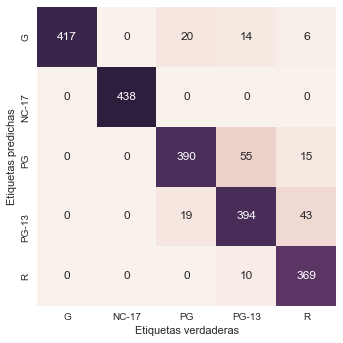

In [17]:
################################################################
########################     XGBOOST      ######################
################################################################
hora_ini = datetime.now()


##Instancio el modelo
model_xgboost = XGBClassifier()


##Fiteo el modelo
model_xgboost.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = model_xgboost.predict(X_test)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=5, min_child_weight=1, n_estimators=50 ................
[CV] max_depth=5, min_child_weight=1, n_estimators=50 ................
[CV] max_depth=5, min_child_weight=1, n_estimators=50 ................
[CV] max_depth=5, min_child_weight=1, n_estimators=500 ...............
[CV] . max_depth=5, min_child_weight=1, n_estimators=50, total=20.6min
[CV] max_depth=5, min_child_weight=1, n_estimators=500 ...............
[CV] . max_depth=5, min_child_weight=1, n_estimators=50, total=20.7min
[CV] max_depth=5, min_child_weight=1, n_estimators=500 ...............
[CV] . max_depth=5, min_child_weight=1, n_estimators=50, total=20.9min
[CV] max_depth=5, min_child_weight=5, n_estimators=50 ................
[CV] . max_depth=5, min_child_weight=5, n_estimators=50, total=18.9min
[CV] max_depth=5, min_child_weight=5, n_estimators=50 ................
[CV] . max_depth=5, min_child_weight=5, n_estimators=50, total=19.2min
[CV] max_depth=5,

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 645.9min finished


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Accuray:  0.95296803653
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       417
          1       1.00      1.00      1.00       438
          2       0.94      0.97      0.95       429
          3       0.88      0.93      0.90       473
          4       0.97      0.88      0.92       433

avg / total       0.95      0.95      0.95      2190

Duration: 12:50:40.942041


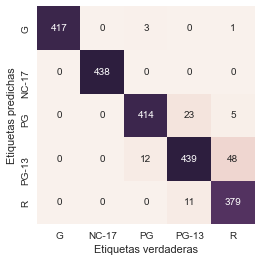

In [16]:
################################################################
########################    XGBOOST  Opt  ######################
################################################################
hora_ini = datetime.now()

##Configuro los parametros
param_trees = {'n_estimators': [50, 500], 
               'max_depth': [5, 20], 
               'min_child_weight':[1, 5]}

##Instancio el modelo
model_xgboost = XGBClassifier()
kf = StratifiedKFold(n_splits=3, shuffle=True)

## Hago el gridsearch
grid_search_xgb = GridSearchCV(model_xgboost, param_grid=param_trees, cv=kf, verbose=2, n_jobs=-1)

##Fiteo el modelo
grid_search_xgb.fit(X_train, y_train)

# Lo utilizamos para predecir en test
y_pred = grid_search_xgb.predict(X_test)

##Veo cual es la configuracion del mejor estimador
print(grid_search_xgb.best_estimator_)

print('Accuray: ', accuracy_score(y_test, y_pred))
#print('AUC: ',roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, y_pred)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))

C_Value: [ 0.001       0.00889796  0.00944898  0.00981633  0.00595918]
Accuray:  0.923287671233
Duration: 1:07:11.180729


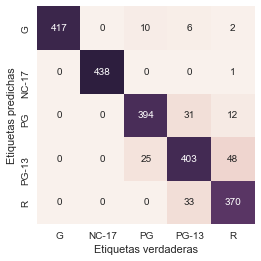

In [14]:
#############################################################
######################## Reg Logistica ######################
#############################################################
hora_ini = datetime.now()

##Inicializo los parametros
c_values = np.linspace(0.001, 0.01, 50)
kf = KFold(n_splits=3, shuffle=True, random_state=12)

# Instanciamos los modelos
logicCV = LogisticRegressionCV(Cs=c_values, cv=kf, fit_intercept=True)

logicCV.fit(X_train, y_train)

print('C_Value:',logicCV.C_)


logic_Test = logicCV.predict(X_test)

print('Accuray: ', accuracy_score(y_test,logic_Test))
#print('AUC: ',roc_auc_score(y_test,logic_Test))

##Calculo la matriz de confusion
mat = confusion_matrix(y_test, logic_Test)

##Grafico la matriz
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(lab_enc.classes_), yticklabels=list(lab_enc.classes_))
plt.xlabel('Etiquetas verdaderas')
plt.ylabel('Etiquetas predichas');

print('Duration: {}'.format(datetime.now() - hora_ini))